In [ ]:
#importing modules
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import os
import wave
import IPython.display as ipd
import subprocess
import cv2
import skvideo.io

In [ ]:
#Defining constants
RGB_CHANNELS=3
MEDIA_DIR = os.path.join(os.getcwd(),"media")
COVER_AUD_PATH = os.path.join(MEDIA_DIR ,'audio.wav')
COVER_AUD_PATH_DEMO = os.path.join(MEDIA_DIR ,'audio_demo.wav')
MESSAGE_AUD_PATH = os.path.join(MEDIA_DIR,'water.wav')
MESSAGE_AUD_PATH_DEMO = os.path.join(MEDIA_DIR,'jedi.wav')
STEGO_AUD_PATH = os.path.join(MEDIA_DIR,"stego_aud.wav")
STEGO_AUD_PATH_DEMO = os.path.join(MEDIA_DIR,"stego_aud_demo.wav")
REC_AUD_PATH = os.path.join(MEDIA_DIR,"rec_aud.wav")
REC_AUD_PATH_DEMO = os.path.join(MEDIA_DIR,"rec_aud_demo.wav")
COVER_IMG_PATH =os.path.join(MEDIA_DIR , 'cover.png')
MESSAGE_IMG_PATH = os.path.join(MEDIA_DIR ,'message.png')
RECOVERED_IMG_PATH = os.path.join(MEDIA_DIR ,'recovered.png')
STEGO_IMG_PATH =os.path.join( MEDIA_DIR , 'stego.png')
COVER_VID_PATH = os.path.join(MEDIA_DIR ,'cover.mp4')
COVER_VID_PATH_NEW = os.path.join(MEDIA_DIR ,'coverNew.mp4')
STEGO_VID_PATH = os.path.join(MEDIA_DIR ,'stego.mp4')
STEGO_VID_PATH_NEW = os.path.join(MEDIA_DIR ,'stego_new.mp4')

**CUDA KERNELS**

In [ ]:
#Audio Steganography Kernels
modAud = SourceModule("""
#define BYTE_SIZE 8
#define LSB_OFF_MASK 0xFE
#define LSB_ON_MASK 0x01
#define POS 1 // 1st bit from LSB
#include <stdint.h>
__device__ __host__ int is_little_endian()
{
    int i = 1;
    char *c = (char *)&i;
    if (*c)
    {
        return 1;
    }
    return 0;
}
__device__ __constant__ uint8_t MASK[BYTE_SIZE]={0x80,0x40,0x20,0x10,0x08,0x04,0x02,0x01};

__global__ void encodeMessageAud(unsigned char *coverAud, unsigned char *messageAud)
{
    int bx = blockIdx.x;
    int tx = threadIdx.x;
    if(tx>=BYTE_SIZE)
      return;
    int messageIdx =bx;
    int coverIdx =bx*BYTE_SIZE + tx;

    char coverByte = coverAud[coverIdx];
    char byte = messageAud[messageIdx];

    coverByte &= LSB_OFF_MASK;  
    char extractedBit = byte & MASK[tx];

    extractedBit = extractedBit >> (BYTE_SIZE - tx - 1);
    if (extractedBit & 0x80000000 || (int)extractedBit < 0)
        extractedBit = 0x01;
    extractedBit = extractedBit << (POS-1);
    coverByte |= extractedBit;

    coverAud[coverIdx] = coverByte;
}

__global__ void decodeMessageAud(unsigned char *stegoAud, unsigned char *recoveredAud)
{
    int bx = blockIdx.x;
    int tx = threadIdx.x;

    if(tx>=BYTE_SIZE)
      return;
    int recoveredIdx =bx;
    int stegoIdx = bx*BYTE_SIZE + tx;


    char stegoByte = stegoAud[stegoIdx];

    char extractedBit = stegoByte & LSB_ON_MASK;
    extractedBit = extractedBit >>(POS-1);
    extractedBit = extractedBit << (BYTE_SIZE - tx - 1);
    __shared__ int tempByte;
    int tempBit = extractedBit;
    if (tx == 0)
    {
        tempByte = (char)0x00;
    }
    atomicOr(&tempByte, tempBit);
    __syncthreads();

    if (tx == 0)
    {
        int EXTRACT_BYTE_MASK = 0x00ff;
        tempByte &= EXTRACT_BYTE_MASK;
        if (!is_little_endian())
        {
            tempByte = tempByte << ((sizeof(int) - 1) * 8);
        }
        char *c = (char *)&tempByte;
        recoveredAud[recoveredIdx] = (*c) & 0xff;
    }
}
""")

In [ ]:
#Video Steganography Kernels
mod = SourceModule("""
#define PIXEL_SIZE 8
#define LSB_OFF_MASK 0xEF
#define LSB_ON_MASK 0x10
#define POS 5 // 5th bit from LSB
#include <stdint.h>
__device__ __host__ int is_little_endian()
{
    int i = 1;
    char *c = (char *)&i;
    if (*c)
    {
        return 1;
    }
    return 0;
}
__device__ __constant__ uint8_t MASK[PIXEL_SIZE]={0x80,0x40,0x20,0x10,0x08,0x04,0x02,0x01};

__global__ void encodeMessageImage(unsigned char *coverImg, unsigned char *messageImg)
{
    int bx = blockIdx.x;
    int by = blockIdx.y;
    int bz = blockIdx.z;
    int bsizeX = gridDim.x;  //WIDTH of the image
    int bsizeZ = gridDim.z;  // CHANNELS in the image
    int tx = threadIdx.x;
    if(tx>=PIXEL_SIZE)
      return;
    int messageIdx = by * (bsizeX * bsizeZ) + bx * bsizeZ + bz;
    int coverIdx = by * (bsizeX * bsizeZ  * PIXEL_SIZE) + bx * bsizeZ * PIXEL_SIZE + bz * PIXEL_SIZE + tx;

    char coverPixel = coverImg[coverIdx];
    char pixel = messageImg[messageIdx];

    coverPixel &= LSB_OFF_MASK;  
    char extractedBit = pixel & MASK[tx];

    extractedBit = extractedBit >> (PIXEL_SIZE - tx - 1);
    if (extractedBit & 0x80000000 || (int)extractedBit < 0)
        extractedBit = 0x01;
    extractedBit = extractedBit << (POS-1);
    coverPixel |= extractedBit;

    coverImg[coverIdx] = coverPixel;
}

__global__ void decodeMessageImage(unsigned char *stegoImg, unsigned char *recoveredImg)
{
    int bx = blockIdx.x;
    int by = blockIdx.y;
    int bz = blockIdx.z;
    int bsizeX = gridDim.x;  //WIDTH
    int bsizeZ = gridDim.z;  // CHANNELS
    int tx = threadIdx.x;

    if(tx>=PIXEL_SIZE)
      return;
    int recoveredIdx = by * (bsizeX * bsizeZ) + bx * bsizeZ + bz;
    int stegoIdx = by * (bsizeX * bsizeZ  * PIXEL_SIZE) + bx * bsizeZ * PIXEL_SIZE + bz * PIXEL_SIZE + tx;


    char stegoPixel = stegoImg[stegoIdx];

    char extractedBit = stegoPixel & LSB_ON_MASK;
    extractedBit = extractedBit >>(POS-1);
    extractedBit = extractedBit << (PIXEL_SIZE - tx - 1);
    __shared__ int tempPixel;
    int tempBit = extractedBit;
    if (tx == 0)
    {
        tempPixel = (char)0x00;
    }
    atomicOr(&tempPixel, tempBit);
    __syncthreads();

    if (tx == 0)
    {
        int EXTRACT_BYTE_MASK = 0x00ff;
        tempPixel &= EXTRACT_BYTE_MASK;
        if (!is_little_endian())
        {
            tempPixel = tempPixel << (sizeof(int) - 1) * 8;
        }
        char *c = (char *)&tempPixel;
        recoveredImg[recoveredIdx] = (*c) & 0xff;
    }
}
""")

In [ ]:
#Assigning Kernels to variables
encodeAud = modAud.get_function("encodeMessageAud")
decodeAud = modAud.get_function("decodeMessageAud")
encode = mod.get_function("encodeMessageImage")
decode = mod.get_function("decodeMessageImage")

**AUDIO STEGANOGRAPHY DEMO**

In [ ]:
# Using song as cover audio and a dialog from Star Wars movie as the message Audio
song = wave.open(COVER_AUD_PATH_DEMO, mode='rb')
frame_bytes = np.asarray(list(song.readframes(song.getnframes()))).astype('uint8')

message = wave.open(MESSAGE_AUD_PATH_DEMO,mode='rb')
msg_frame_bytes = np.asarray((list(message.readframes(message.getnframes())))).astype('uint8')

N_BYTES_COVER = len(frame_bytes)
N_BYTES_MSG = len(msg_frame_bytes)

In [1]:
# #Cover Audio
# ipd.Audio(COVER_AUD_PATH_DEMO)

In [2]:
# #Message Audio
# ipd.Audio(MESSAGE_AUD_PATH_DEMO)

In [ ]:
# Defining Grids and Block size
GRID_AUD =  (N_BYTES_MSG,1,1)
BLOCK =(32,1,1)


In [ ]:
# Embedding Message Audio into Cover Audio
d_frame_bytes = cuda.mem_alloc(frame_bytes.nbytes)
d_msg_frame_bytes = cuda.mem_alloc(msg_frame_bytes.nbytes)
cuda.memcpy_htod(d_frame_bytes,frame_bytes)
cuda.memcpy_htod(d_msg_frame_bytes,msg_frame_bytes)
encodeAud(d_frame_bytes,d_msg_frame_bytes,block=BLOCK,grid=GRID_AUD) # Kernel Execution
cuda.memcpy_dtoh(frame_bytes,d_frame_bytes)
d_frame_bytes.free()
d_msg_frame_bytes.free()
with wave.open(STEGO_AUD_PATH_DEMO, 'wb') as fd:
    fd.setparams(song.getparams())
    fd.writeframes(frame_bytes)

In [4]:
# #Stego Audio
# ipd.Audio(STEGO_AUD_PATH_DEMO)

In [ ]:
# Extracting Audio from Stego Audio
stego_aud = wave.open(STEGO_AUD_PATH_DEMO, mode='rb')
stego_frame_bytes = np.asarray(list(stego_aud.readframes(stego_aud.getnframes()))).astype('uint8')
rec_frame_bytes = np.zeros_like(msg_frame_bytes)
d_stego_frame_bytes = cuda.mem_alloc(stego_frame_bytes.nbytes)
cuda.memcpy_htod(d_stego_frame_bytes,stego_frame_bytes)
d_rec_frame_bytes = cuda.mem_alloc(msg_frame_bytes.nbytes)
decodeAud(d_stego_frame_bytes,d_rec_frame_bytes,block=BLOCK,grid=GRID_AUD)
cuda.memcpy_dtoh(rec_frame_bytes,d_rec_frame_bytes)
d_rec_frame_bytes.free()
d_stego_frame_bytes.free()
with wave.open(REC_AUD_PATH_DEMO, 'wb') as fd:
    fd.setparams(message.getparams())
    fd.writeframes(rec_frame_bytes)

In [3]:
# # Recovered Audio
# ipd.Audio(REC_AUD_PATH_DEMO)

In [ ]:
song.close()
message.close()

**IMAGE STEGANOGRAPHY DEMO**

In [ ]:
#Defining Grid & Block size
n_frames=-1
GRID = None
BLOCK = (32,1,1)

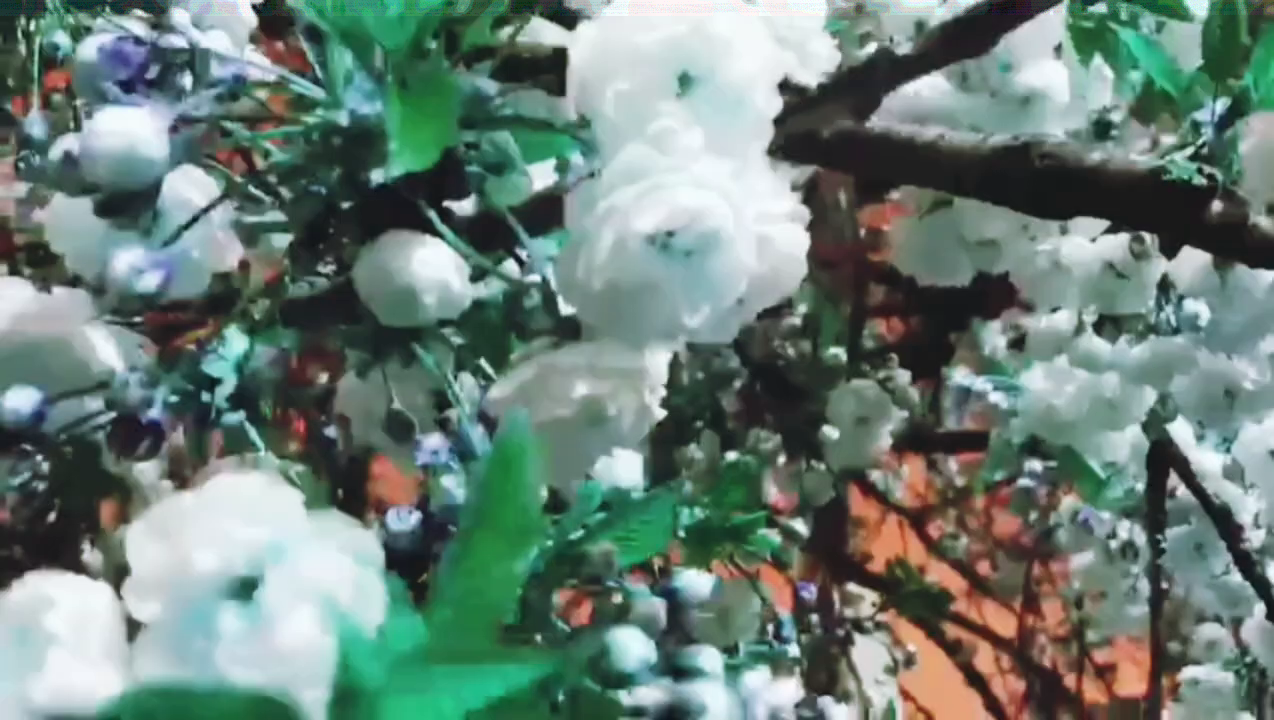

In [ ]:
# Embedding message image into one of the frames of mp4 file
messageImg = Image.open(MESSAGE_IMG_PATH).crop((0,25,50,75)).convert('RGB')
global messageFlat,msgBytes,mWidth,mHeight
cap = cv2.VideoCapture(COVER_VID_PATH)
ret,frame=cap.read()
messageArr = np.asarray(messageImg)
messageFlat = messageArr.flatten().astype('uint8')
mWidth = messageImg.width
mHeight=messageImg.height
msgBytes = messageFlat.nbytes
frameFlat = frame.flatten()
GRID=(messageImg.width,messageImg.height,RGB_CHANNELS)
encode(cuda.InOut(frameFlat),cuda.In(messageFlat),block=BLOCK,grid=GRID) #Kernel Execution
stegoImg = Image.fromarray(frameFlat.reshape(frame.shape))
stegoImg.save("./temp.png")
display(stegoImg) #Stego Image is displayed below

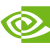

In [ ]:
# Decoding message image
stegoImg = Image.open('./temp.png')
stegoFlat = np.asarray(stegoImg).flatten().astype('uint8')
d_stegoArr = cuda.mem_alloc(stegoFlat.nbytes)
cuda.memcpy_htod(d_stegoArr,stegoFlat)
d_recoveredArr = cuda.mem_alloc(messageArr.nbytes)
decode(d_stegoArr,d_recoveredArr,block=BLOCK,grid=GRID)
recoveredArr = np.zeros_like(messageArr)
cuda.memcpy_dtoh(recoveredArr,d_recoveredArr)
recImg = Image.fromarray(recoveredArr)
recImg.save("rec.png")
display(recImg)

**INTEGRATED AUDIO-MP4 STEGANOGRAPHY**

In [ ]:
#Extract audio from mp4 file
command = f'ffmpeg -i {COVER_VID_PATH} -ab 160k -ac 2 -ar 44100 -vn {COVER_AUD_PATH}'
subprocess.call(command, shell=True)

1

In [5]:
# #Extracted Audio from Cover mp4 file
# ipd.Audio(COVER_AUD_PATH)

In [6]:
# #Message Audio
# ipd.Audio(MESSAGE_AUD_PATH)

In [ ]:
#Create numpy arrays of wav files
song = wave.open(COVER_AUD_PATH, mode='rb')
frame_bytes = np.asarray(list(song.readframes(song.getnframes()))).astype('uint8')

message = wave.open(MESSAGE_AUD_PATH,mode='rb')
msg_frame_bytes = np.asarray((list(message.readframes(message.getnframes())))).astype('uint8')

N_BYTES_COVER = len(frame_bytes)
N_BYTES_MSG = len(msg_frame_bytes)

In [ ]:
#Re-defining Grid & Block Size
GRID_AUD =  (N_BYTES_MSG,1,1)
BLOCK =(32,1,1)

In [ ]:
# Embedding Message Audio into Cover Audio
d_frame_bytes = cuda.mem_alloc(frame_bytes.nbytes)
d_msg_frame_bytes = cuda.mem_alloc(msg_frame_bytes.nbytes)
cuda.memcpy_htod(d_frame_bytes,frame_bytes)
cuda.memcpy_htod(d_msg_frame_bytes,msg_frame_bytes)
encodeAud(d_frame_bytes,d_msg_frame_bytes,block=BLOCK,grid=GRID_AUD)
cuda.memcpy_dtoh(frame_bytes,d_frame_bytes)
d_frame_bytes.free()
d_msg_frame_bytes.free()
with wave.open(STEGO_AUD_PATH, 'wb') as fd:
    fd.setparams(song.getparams())
    fd.writeframes(frame_bytes)

In [7]:
# #Stego Audio
# ipd.Audio(STEGO_AUD_PATH)

In [ ]:
# Defining functions for MP4 Steganography
DESIRED_WIDTH=1280
DESIRED_HEIGHT=720

def get_frame_types(video_fn):
    command = 'ffprobe -v error -show_entries frame=pict_type -of default=noprint_wrappers=1'.split()
    out = subprocess.check_output(command + [video_fn]).decode()
    frame_types = out.replace('pict_type=','').split()
    global n_frames
    n_frames=len(frame_types)
    return zip(range(len(frame_types)), frame_types)

def convertFile(coverVidPathOrg,coverVidPath):
      cap = cv2.VideoCapture(coverVidPathOrg)
      fps = cap.get(cv2.CAP_PROP_FPS)
      height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
      writer = skvideo.io.FFmpegWriter(coverVidPath, outputdict={
          '-vcodec': 'libx264',  #use the h.264 codec
          '-crf': '0',           #set the constant rate factor to 0, which is lossless
          '-preset':'veryslow'   #the slower the better compression, in princple, try 
                         #other options see https://trac.ffmpeg.org/wiki/Encode/H.264
      })
#       fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#       out = cv2.VideoWriter(coverVidPath,fourcc,fps,(width,height))

      while(cap.isOpened()):
        ret,frame = cap.read()
        if not ret:
            break
#         frame=frame[:DESIRED_HEIGHT,:DESIRED_WIDTH,:]
#         out.write(frame)
        writer.writeFrame(frame)
      cap.release()
      writer.close()
#       out.release()

    
def encodeMessage(messageImgPath,coverPath,stegoPath):
      cap = cv2.VideoCapture(coverPath)
      fps = cap.get(cv2.CAP_PROP_FPS)
      height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#       print(f'{int(cap.get(cv2.CAP_PROP_FOURCC))}')
#       fourcc = cv2.VideoWriter_fourcc('x','2','6','4')
      fourcc=int(cap.get(cv2.CAP_PROP_FOURCC))
      
      print(f'FOURCC_MP4:{fourcc}') 
#       pxl_fmt = cap.get(cv.CAP_PROP_CODEC_PIXEL_FORMAT)
#       try:
#         out = cv2.VideoWriter(stegoPath,fourcc,fps,(width,height))
#       except cv2.error as e:
#         print(e)
#         print("returning")
#         return
#       out.set(cv.CAP_PROP_CODEC_PIXEL_FORMAT,pxl_fmt)
      writer = skvideo.io.FFmpegWriter(stegoPath, outputdict={
          '-vcodec': 'libx264',  #use the h.264 codec
          '-crf': '0',           #set the constant rate factor to 0, which is lossless
          '-preset':'veryslow'   #the slower the better compression, in princple, try 
                         #other options see https://trac.ffmpeg.org/wiki/Encode/H.264
      })
      foundI = False
      messageImg = Image.open(messageImgPath).crop((0,25,50,75))
      messageImg = messageImg.convert('RGB')
      messageArr = np.asarray(messageImg)
      global messageFlat
      messageFlat = messageArr.astype('uint8').flatten()
      global msgBytes,mWidth,mHeight
      mWidth = messageImg.width
      mHeight = messageImg.height
      msgBytes = messageFlat.nbytes
      i_frames = get_frame_types(coverPath)
      for i,type in i_frames:
        ret,frame = cap.read()
        if not ret:
          break
        curr_frame=frame
        if type =='I' and not foundI:
          frameFlat = frame.flatten().astype('uint8')
          d_coverArr = cuda.mem_alloc(frame.nbytes)
          d_messageArr = cuda.mem_alloc(messageFlat.nbytes)
          cuda.memcpy_htod(d_coverArr,frameFlat)
          cuda.memcpy_htod(d_messageArr,messageFlat)
          global GRID
          GRID=(messageImg.width,messageImg.height,RGB_CHANNELS)
          try:
              encode(d_coverArr,d_messageArr,block=BLOCK,grid=GRID)
          except:
            print("encode err")
          try:
              stegoFlat = np.zeros_like(frame)
          except:
              print("np.zeros_like err")
          cuda.memcpy_dtoh(stegoFlat,d_coverArr)
          stegoArr =stegoFlat.reshape((height,width,-1))
          curr_frame=stegoArr
          imshow(stegoArr)
          foundI=True
#         try:
#           out.write(curr_frame)
#         except cv2.error as e:
#           print(e)
        writer.writeFrame(curr_frame)
      cap.release()
#       out.release()
      writer.close()
  
def decodeMessage(recImgPath,stegoPath):
      cap = cv2.VideoCapture(stegoPath)
      i_frames = get_frame_types(stegoPath)
      for i,type in i_frames:
        ret,frame = cap.read()
        if not ret:
          break
        if type =='I':
          stegoFlat = frame.flatten().astype('uint8')
          d_stegoArr = cuda.mem_alloc(stegoFlat.nbytes)
          cuda.memcpy_htod(d_stegoArr,stegoFlat)
          d_recoveredArr = cuda.mem_alloc(msgBytes)
          decode(d_stegoArr,d_recoveredArr,block=BLOCK,grid=GRID)
          recoveredFlat = np.zeros_like(messageFlat)
          cuda.memcpy_dtoh(recoveredFlat,d_recoveredArr)
          recImg = Image.fromarray(recoveredFlat.reshape((mHeight,mWidth,-1)))
          recImg.save(recImgPath)
          break
      cap.release()



**EMBEDDING PHASE**

In [ ]:
# Converting mp4 files to a common CODEC for the project
# In this demo, I'll not be running this cell to save time as it takes more than 10 minutes to convert the given mp4 file
# and I have already converted the file, so I'll be using that as cover in the next cell.
convertFile(COVER_VID_PATH,COVER_VID_PATH_NEW)

FOURCC_MP4:828601953


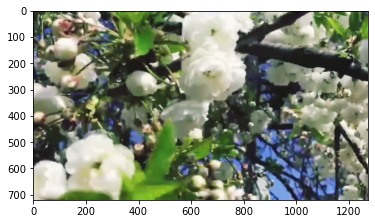

In [ ]:
# Embedding Message Image into MP4 File
encodeMessage(MESSAGE_IMG_PATH,COVER_VID_PATH_NEW,STEGO_VID_PATH)

In [ ]:
# Combining Stego Audio with Stego MP4
command = f'ffmpeg -y -i {STEGO_VID_PATH} -i {STEGO_AUD_PATH} -c:v copy -c:a aac -strict experimental {STEGO_VID_PATH_NEW}'
subprocess.call(command,shell = True)

0

**EXTRACTION PHASE**

In [ ]:
# Extracting Audio file from MP4 Stego
command = f'ffmpeg -i {STEGO_VID_PATH_NEW} -ab 160k -ac 2 -ar 44100 -vn {STEGO_AUD_PATH}'
subprocess.call(command, shell=True)

1

In [ ]:
# Extracting Audio from Stego Audio
stego_aud = wave.open(STEGO_AUD_PATH, mode='rb')
stego_frame_bytes = np.asarray(list(stego_aud.readframes(stego_aud.getnframes()))).astype('uint8')
rec_frame_bytes = np.zeros_like(msg_frame_bytes)
d_stego_frame_bytes = cuda.mem_alloc(stego_frame_bytes.nbytes)
cuda.memcpy_htod(d_stego_frame_bytes,stego_frame_bytes)
d_rec_frame_bytes = cuda.mem_alloc(msg_frame_bytes.nbytes)
decodeAud(d_stego_frame_bytes,d_rec_frame_bytes,block=BLOCK,grid=GRID_AUD)
cuda.memcpy_dtoh(rec_frame_bytes,d_rec_frame_bytes)
d_rec_frame_bytes.free()
d_stego_frame_bytes.free()
with wave.open(REC_AUD_PATH, 'wb') as fd:
    fd.setparams(message.getparams())
    fd.writeframes(rec_frame_bytes)

In [8]:
# # Recovered Audio
# ipd.Audio(REC_AUD_PATH)

In [ ]:
#Extracting hidden image
decodeMessage(RECOVERED_IMG_PATH,STEGO_VID_PATH_NEW)


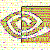

In [ ]:
rec_img = Image.open(RECOVERED_IMG_PATH)
display(rec_img)

**THE END**